In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.5.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 21.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import torch_geometric as torch_geometric
import math

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
import numpy as np

from torch_geometric.datasets import TUDataset, Planetoid, BAShapes
from torch_geometric.datasets import Reddit
from torch_geometric.data import Data, DataLoader

import torch_geometric.transforms as T

#from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv,GINConv
from torch.distributions import Bernoulli,Categorical

In [ ]:
from torch_geometric.datasets import BA2MotifDataset
dataset=TUDataset(root="/data",name='REDDIT-BINARY')

Processing...
Done!


In [ ]:
import torch
from torch_geometric.data import Data

def assign_node_features(data_list, feature_dim=10, feature_value=0.1):
    """
    Assigns a constant feature vector to each node in a list of PyTorch Geometric Data objects.

    Args:
        data_list (list): List of PyTorch Geometric Data objects.
        feature_dim (int): Dimension of the feature vector to assign. Default is 10.
        feature_value (float): Value to fill in the feature vector. Default is 0.1.

    Returns:
        list: A list of Data objects with updated node features.
    """
    newdata=[]
    for data in data_list:
        num_nodes = data.num_nodes
        data.x = torch.full((num_nodes, feature_dim), feature_value)
        newdata.append(data)
        #print(data.x)
    return newdata


In [ ]:
dataset=assign_node_features(dataset)
print(dataset[0])

Data(edge_index=[2, 480], y=[1], num_nodes=218, x=[218, 10])


In [ ]:
import random
torch.manual_seed(12345)
random.shuffle(dataset)
print(len(dataset))

train_dataset = dataset[:1800]
test_dataset = dataset[1800:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

2000
Number of training graphs: 1800
Number of test graphs: 200


In [ ]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 59828], y=[64], num_nodes=25987, x=[25987, 10], batch=[25987], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 73874], y=[64], num_nodes=31344, x=[31344, 10], batch=[31344], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 72450], y=[64], num_nodes=31825, x=[31825, 10], batch=[31825], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 68902], y=[64], num_nodes=30118, x=[30118, 10], batch=[30118], ptr=[65])

Step 5:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 62660], y=[64], num_nodes=27258, x=[27258, 10], batch=[27258], ptr=[65])

Step 6:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 56658], y=[64], num_nodes=24316, x=[24316, 10], batch=[24316], ptr=[65])

Step 7:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 61582], y=[64], num_nodes=26288

In [ ]:
exdata=dataset[0]
print(exdata.x)

tensor([[0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        ...,
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000]])


In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GCNEncoder(torch.nn.Module):
    def __init__(self, inputdim,hidden_channels):
        super(GCNEncoder, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(inputdim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn = torch.nn.BatchNorm1d(hidden_channels)
        self.dropout = torch.nn.Dropout(0.5)
        self.leaky_relu = torch.nn.LeakyReLU(0.2)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.leaky_relu(x)
        x = self.conv2(x, edge_index)
        x = self.leaky_relu(x)
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)
        x = self.bn(x)
        x = F.dropout(x, p=0.5, training=self.training)
        return x

class LinearClassifier(torch.nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LinearClassifier, self).__init__()
        self.linear = Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)
class CombinedModel(torch.nn.Module):
    def __init__(self,inputdim, hidden_channels, num_classes):
        super(CombinedModel, self).__init__()
        self.encoder = GCNEncoder(inputdim,hidden_channels)
        self.classifier = LinearClassifier(input_dim=hidden_channels, num_classes=num_classes)

    def forward(self, x, edge_index, batch):
        # Get the embeddings from the encoder
        embeddings = self.encoder(x, edge_index, batch)

        # Get the logits from the classifier
        logits = self.classifier(embeddings)

        return embeddings, logits
num_features=10
inputdim=num_features
model=CombinedModel(inputdim, hidden_channels=64,num_classes=2)


In [ ]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Add a learning rate scheduler
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
# def train():
#     model.train()

#     for epoch in range(num_epochs):
#         for data in train_loader:  # Iterate in batches over the training dataset.
#             embedding,  out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
#             #print(out)
#             loss = criterion(out, data.y)  # Compute the loss.
#             loss.backward()  # Derive gradients.
#             optimizer.step()  # Update parameters based on gradients.
#             optimizer.zero_grad()  # Clear gradients.

#         # Update the learning rate scheduler
#         scheduler.step()

#         # Print the current learning rate every epoch (optional)
#         print(f"Epoch {epoch + 1}/{num_epochs}, Learning Rate: {scheduler.get_last_lr()[0]}",loss)
#         # train_acc = test(train_loader)
#         # test_acc = test(test_loader)
#         # print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
def train():
    model.train()

    for epoch in range(num_epochs):
        for data in train_loader:  # Iterate in batches over the training dataset.
            # Forward pass
            x, edge_index, batch = data.x, data.edge_index, data.batch
            embedding, out = model(x, edge_index, batch)

            # Compute the loss
            loss = criterion(out, data.y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Update the learning rate scheduler
        scheduler.step()

        # Print the current learning rate and loss every epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, Learning Rate: {scheduler.get_last_lr()[0]}, Loss: {loss.item()}")

# Set the number of epochs
num_epochs = 2000

# Call the training loop
train()


# # Set the number of epochs
# num_epochs = 800

# # Call the training loop
# train()



Epoch 1/2000, Learning Rate: 0.0099, Loss: 0.9864181280136108
Epoch 2/2000, Learning Rate: 0.009801, Loss: 0.47614172101020813
Epoch 3/2000, Learning Rate: 0.00970299, Loss: 0.4890369474887848
Epoch 4/2000, Learning Rate: 0.0096059601, Loss: 0.38356339931488037
Epoch 5/2000, Learning Rate: 0.009509900499, Loss: 0.2011270374059677
Epoch 6/2000, Learning Rate: 0.00941480149401, Loss: 0.8649755120277405
Epoch 7/2000, Learning Rate: 0.0093206534790699, Loss: 0.3711922764778137
Epoch 8/2000, Learning Rate: 0.0092274469442792, Loss: 1.342658519744873
Epoch 9/2000, Learning Rate: 0.009135172474836408, Loss: 0.380023330450058
Epoch 10/2000, Learning Rate: 0.009043820750088045, Loss: 0.39921078085899353
Epoch 11/2000, Learning Rate: 0.008953382542587164, Loss: 0.37606877088546753
Epoch 12/2000, Learning Rate: 0.008863848717161293, Loss: 0.38412314653396606
Epoch 13/2000, Learning Rate: 0.00877521022998968, Loss: 0.7792664766311646
Epoch 14/2000, Learning Rate: 0.008687458127689783, Loss: 0.3969

KeyboardInterrupt: 

In [ ]:
def degree_distribution(data, N):
    # Find all unique nodes present in the edge index tensor
    all_nodes = torch.unique(torch.cat((data.edge_index[0], data.edge_index[1])))

    # Calculate the number of nodes
    num_nodes = int(all_nodes.max()) + 1 if all_nodes.numel() > 0 else 0  # If there are no nodes, set num_nodes to 0

    # Calculate the degree of each node
    degrees = torch.bincount(data.edge_index[0], minlength=num_nodes)

    # Convert degrees to degree distribution
    degree_values = torch.bincount(degrees)

    # Make sure the tensor is of length N
    degree_distribution = torch.cat((degree_values, torch.zeros(max(N - len(degree_values), 0)).to(degree_values.device)))

    return degree_distribution


def clustering_coefficient(data):
    # Ensure the graph is undirected
    #data = to_undirected(data)

    # Calculate the number of nodes
    num_nodes = data.x.shape[0]

    # Calculate the number of triangles each node is involved in
    num_triangles = torch.zeros(num_nodes, dtype=torch.float)

    # Calculate the number of connected triples each node is involved in
    num_connected_triples = torch.zeros(num_nodes, dtype=torch.float)

    # Iterate over each edge in the graph
    for i, j in data.edge_index.t().tolist():
        # Get the neighbors of node i and node j
        neighbors_i = set(data.edge_index[1][data.edge_index[0] == i].tolist())
        neighbors_j = set(data.edge_index[1][data.edge_index[0] == j].tolist())

        # Calculate the number of common neighbors between i and j
        common_neighbors = neighbors_i.intersection(neighbors_j)

        # Update the number of triangles and connected triples for nodes i and j
        num_triangles[i] += len(common_neighbors)
        num_triangles[j] += len(common_neighbors)
        num_connected_triples[i] += len(neighbors_i) - 1
        num_connected_triples[j] += len(neighbors_j) - 1

    # Print intermediate results for debugging
    #print("Number of triangles per node:", num_triangles)
    #print("Number of connected triples per node:", num_connected_triples)

    # Calculate the local clustering coefficient for each node
    local_clustering_coefficient = (num_triangles / 2) / num_connected_triples
    local_clustering_coefficient[torch.isnan(local_clustering_coefficient)] = 0  # Set NaN values to 0

    # Print intermediate results for debugging
    #print("Local clustering coefficient per node:", local_clustering_coefficient)

    # Calculate the average clustering coefficient
    avg_clustering_coefficient = local_clustering_coefficient.mean()

    return avg_clustering_coefficient
import torch
import torch_geometric
import numpy as np

def spectrum_distribution(data, k):
    # Convert PyTorch Geometric Data object to a dense adjacency matrix
    num_nodes = data.num_nodes
    adj_matrix = torch_geometric.utils.to_dense_adj(data.edge_index).squeeze(0)

    # Calculate degree matrix
    degree = torch.sum(adj_matrix, dim=1)
    degree_matrix = torch.diag(degree)

    # Calculate Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix

    # Convert Laplacian to dense matrix and numpy array
    laplacian_dense = laplacian_matrix.numpy()

    # Compute eigenvalues
    eigenvalues, _ = np.linalg.eig(laplacian_dense)

    # Sort eigenvalues in ascending order
    eigenvalues = np.sort(eigenvalues)

    # If k is greater than the number of eigenvalues, pad with zeros
    if k > len(eigenvalues):
        padded_eigenvalues = np.pad(eigenvalues, (0, k - len(eigenvalues)), 'constant')
    else:
        padded_eigenvalues = eigenvalues[:k]

    return padded_eigenvalues.astype(np.complex128)




In [ ]:
import torch
import torch_geometric
import numpy as np

def spectrum_distribution(data, k):
    # Convert PyTorch Geometric Data object to a dense adjacency matrix
    num_nodes = data.num_nodes
    adj_matrix = torch_geometric.utils.to_dense_adj(data.edge_index).squeeze(0)

    # Calculate degree matrix
    degree = torch.sum(adj_matrix, dim=1)
    degree_matrix = torch.diag(degree)

    # Calculate Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix

    # Convert Laplacian to dense matrix and numpy array
    laplacian_dense = laplacian_matrix.numpy()

    # Compute eigenvalues
    eigenvalues, _ = np.linalg.eig(laplacian_dense)

    # Sort eigenvalues in ascending order
    eigenvalues = np.sort(eigenvalues)

    # If k is greater than the number of eigenvalues, pad with zeros
    if k > len(eigenvalues):
        padded_eigenvalues = np.pad(eigenvalues, (0, k - len(eigenvalues)), 'constant')
    else:
        padded_eigenvalues = eigenvalues[:k]

    return padded_eigenvalues

# Example usage
# Assuming 'data' is your PyTorch Geometric Data object and 'k' is the desired number of eigenvalues
# eigenvalues = spectrum_distribution(data, k)



In [ ]:
max_num_nodes = max(data.x.size(0) if data.x is not None else data.edge_index.max().item() + 1 for data in dataset)
print(max_num_nodes)

3782


In [ ]:
def get_max_nodes(graph_list):
    """
    Returns the maximum number of nodes in the largest graph in the input list.

    Parameters:
    graph_list (list of torch_geometric.data.Data): A list of PyTorch Geometric Data objects.

    Returns:
    int: The maximum number of nodes in the largest graph.
    """
    if not graph_list:
        raise ValueError("The input list is empty.")

    max_nodes = max(graph.num_nodes for graph in graph_list)
    return max_nodes

In [ ]:
max_num_nodes=get_max_nodes(dataset)
print(max_num_nodes)

3782


In [ ]:
# Separating the graphs into two classes according to the model
N=3782
data1=[]
data2=[]
latent_data1=[]
latent_data2=[]
degreedist1=[]
degreedist2=[]
cluscoeff1=[]
cluscoeff2=[]
spec1=[]
spec2=[]

for i in range(len(dataset)):
    model.eval()
    data=dataset[i]
    embedding , out = model(data.x, data.edge_index, data.batch)
    pred = out.argmax(dim=1)
    if(pred==0):
        data1.append(data)
        latent_data1.append(embedding)
        degree=degree_distribution(data,N)
        clus=clustering_coefficient(data)
        spec=spectrum_distribution(data,N)
        cluscoeff1.append(clus)
        degreedist1.append(degree)
        spec1.append(spec)

    else:
        data2.append(data)
        latent_data2.append(embedding)
        degree=degree_distribution(data,N)
        degreedist2.append(degree)
        clus=clustering_coefficient(data)
        cluscoeff2.append(clus)
        spec=spectrum_distribution(data,N)
        spec2.append(spec)
print(len(data1))
print(len(data2))

print(data.batch)

latent_explanations=[]


1
1999
None


In [ ]:
def GraphRepModel(N,classdata):
    B=np.zeros(N)# Node Type Matrix for nodes of 10 types
    X=np.zeros((N,10))
    numgraphs=len(classdata)
    workingdata=classdata

    #Learning the on/off bit and node representations
    for i in range(numgraphs):#len(data1))
        data=workingdata[i]
        x=data.x
        k=len(data.x) # keeping tab of the number of nodes in the ith graph
        #print(k)
        x=x.numpy()

        B[0:k]+=1
        #print(B)
        X[:x.shape[0], :] += x
    B1=B
    B=np.reshape(B,(N,-1))
    mean_estimate=X/B

    #print(mean_estimate)
    covarr=np.zeros((10,10,N))

    for i in range(numgraphs):
        data=workingdata[i]
        x=data.x
        #print(len(x))
        x=x.numpy()
        subtracted_array = x-mean_estimate[:x.shape[0], :]
        result_matrices=[]
        for row in subtracted_array:
          element = row.reshape(10, 1)  # Reshape to a 2x1 element
          result_matrix = np.dot(element, element.T)  # Multiply by its transpose
          result_matrices.append(result_matrix)

    # Concatenate the resulting 2x2 matrices along the third dimension to create a 3D array
        result_array = np.stack(result_matrices, axis=2)
        #print(result_array.shape)
        covarr[:, :, :result_array.shape[2]] += result_array
    print(covarr.shape)
    covariance_estimate=covarr/B[:,None,None]
    #print(covariance_estimate.shape)
    print(covariance_estimate.shape)
    result_list=[]
    for i in range(N):
        result_list.append(covarr[:, :, i] / B[i])

    # Convert the list of results back to a NumPy array
    result = np.stack(result_list, axis=2)
    print(result.shape)
    Bdist=B/numgraphs
    Adj=np.zeros((N,N))# Edge type count for only two types edge present/edge absent
    for i in range(len(workingdata)):
        data=workingdata[i]
        adj=data.edge_index
        rowlen=len(adj[0][:])
        #print(rowlen)
        #print(adj[:][0])
        #print(adj[:][1])
        for j in range(rowlen):
            k1=adj[0][j]
            k2=adj[1][j]
            Adj[k1][k2]+=1

    #Learning the parameters for the distribution of nodes
    #numgraphs=len(data1)
    #X=X/numgraphs #converting X to the node distribution matrix
    Adj=Adj/numgraphs
    return Bdist, mean_estimate, result, Adj


In [ ]:
from torch_geometric.utils import to_networkx
def GraphSampler(N,Bdist,mean_estimate, result, Adj,show=False):
  Bdist=np.concatenate(Bdist)
  #print(Bdist)
  samples = [np.random.choice([0, 1], p=[1 - p, p]) for p in Bdist]
  #print(samples[1])
  nodefeat=[]
  for i in range(N):
    if(samples[i]!=0):
      meanvec=mean_estimate[i,:]
      covarvec=result[:,:,i]
      normalsamples = np.random.multivariate_normal(meanvec, covarvec, 1)
      nodefeat.append(normalsamples)
  Adjacencymat=np.random.binomial(1,Adj)
  #print(Adjacencymat.shape)
  #print(Adjacencymat[3][5])
  nodefeat=np.vstack(nodefeat)

  nodefeat=torch.tensor(nodefeat)
  #nodefeat=nodefeat.double()
  #print(nodefeat)
  merged_array = np.vstack(nodefeat)
  #print(nodefeat.shape)
  k=nodefeat.shape[0]
  for i in range(N):
    for j in range(N):
      if (i>k-1 or j> k-1):
        Adjacencymat[i][j]=0
    # Convert the NumPy array to a PyTorch tensor
  adjacency_matrix = torch.tensor(Adjacencymat)

  # Find the non-zero indices in the adjacency matrix
  edge_indices = torch.nonzero(adjacency_matrix, as_tuple=False).t()
  edge_indices=edge_indices.long()
  newdata=Data(x=nodefeat,edge_index=edge_indices)
  newdata.x=newdata.x.float()
  newdata.pos=newdata.x
  #print(newdata.x.dtype)
  #print(newdata.x)
  #print(newdata.edge_index)
  embedding, out=model(newdata.x,newdata.edge_index,newdata.batch)
  soft=torch.nn.Softmax(dim=1)
  explainergraph=to_networkx(newdata,to_undirected=True)
  degreedist=degree_distribution(newdata,N)
  cluscoeffexp=clustering_coefficient(newdata)
  specdist=spectrum_distribution(newdata,N)
  if show:
    plot_graph_with_color(newdata,mean_class1,mean_class2)

  problities=soft(out)
  explainernodes=nx.number_of_nodes(explainergraph)
  explaineredges=nx.number_of_edges(explainergraph)
  explainerdensity=(explaineredges)/(explainernodes*explainernodes)
  return problities, explainerdensity, embedding, degreedist, cluscoeffexp, specdist






In [ ]:
N=25
Bdist, mean_estimate, result, Adj =GraphRepModel(N,data1)


(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)


In [ ]:
problities, explainerdensity, embedding,degreedist,cluscoeff,specdist= GraphSampler(N, Bdist, mean_estimate, result, Adj)
print(problities)

tensor([[1.0000e+00, 1.1403e-30]], grad_fn=<SoftmaxBackward0>)


In [ ]:
def Dpc(dataset,threshold):
  boundary1=[]
  boundary2=[]
  m=torch.nn.Softmax(dim=1)
  for i in range(len(dataset)):
      model.eval()
      data=dataset[i]
      embedding , out = model(data.x, data.edge_index, data.batch)
      probs=m(out)
      #out=torch.nn.Softmax(out,dim=0)
      #pred = out.argmax(dim=1)
      if(threshold<probs[0][0]):
          boundary1.append(data)
          #latent_data1.append(embedding)
      if(threshold <probs[0][1]):
          boundary2.append(data)
  return boundary1 , boundary2


In [ ]:
import statistics
def sensitivityanalysis(N, Bdist, mean_estimate, result, Adj,numsample,label):
  epsilon=0.01
  alpha=0.0
  #perturbedX=perturbX(X,epsilon)
  #perturbedAdj=perturbadj(Adj,epsilon)
  meanaccuracy=[]
  stdaccuracy=[]
  meandensity=[]
  stddensity=[]
  MMD=[]

  while(alpha==0.0):
    accuracy=[]
    density=[]
    embeddings=[]
    degreedistlist=[]
    cluslist=[]
    speclist=[]
    for i in range(100):
      # newX=X#nodefeatcomb(perturbedX,X,alpha)
      # newAdj=Adj#adjcomb(perturbedAdj,Adj,alpha)
      maxscore=-1
      sampleaccuracy=0
      sampledensity=0
      sampleembedding=0
      sampledeg=0
      sampleclus=0
      samplespec=0

      for num in range(numsample):
        problities,explainerdensity,embedding,degreedistb,clus,spec=GraphSampler(N, Bdist, mean_estimate, result, Adj)
        #max=problities[0][label]
        if(problities[0][label]>maxscore):
          sampleaccuracy=problities[0][label]
          sampledensity=explainerdensity
          sampleembedding=embedding
          sampledeg=degreedistb
          sampleclus=clus
          samplespec=spec
          maxscore=problities[0][label]
        #print(maxscore)
        accuracy.append(sampleaccuracy)
        density.append(sampledensity)
        embeddings.append(sampleembedding)
    meanacc=torch.mean(torch.stack(accuracy))
    stdacc=torch.std(torch.stack(accuracy))
    meanden=statistics.mean(density)
    stdden=statistics.stdev(density)
    meanaccuracy.append(meanacc)
    stdaccuracy.append(stdacc)
    meandensity.append(meanden)
    stddensity.append(stdden)
    # MMDdist=mmd_kernel(torch.cat(latent,dim=0),torch.cat(embeddings,dim=0),gaussian_kernel)
    # MMD.append(MMDdist)
    alpha+=0.05
  return meanaccuracy , stdaccuracy

In [ ]:
def mmd_kernel(X, Y, kernel_func):
    """
    Compute Maximum Mean Discrepancy (MMD) between two samples using a given kernel function.

    Parameters:
    - X: torch.Tensor, shape (n_samples, n_features)
    - Y: torch.Tensor, shape (m_samples, n_features)
    - kernel_func: function, kernel function to compute pairwise kernel values

    Returns:
    - mmd: float, Maximum Mean Discrepancy
    """
    m, n = len(X), len(Y)

    # Compute kernel matrices
    K_xx = kernel_func(X, X)
    K_yy = kernel_func(Y, Y)
    K_xy = kernel_func(X, Y)

    # Compute MMD statistic
    mmd = 1.0 / (m * (m - 1)) * torch.sum(K_xx - torch.diag(torch.diagonal(K_xx))) + \
          1.0 / (n * (n - 1)) * torch.sum(K_yy - torch.diag(torch.diagonal(K_yy))) - \
          2.0 / (m * n) * torch.sum(K_xy)

    return mmd.item()  # Convert the result to a Python float

# Example of using a Gaussian (RBF) kernel function for PyTorch
def gaussian_kernel(X, Y, sigma=1.0):
    """
    Gaussian (RBF) kernel function.

    Parameters:
    - X: torch.Tensor, shape (n_samples, n_features)
    - Y: torch.Tensor, shape (m_samples, n_features)
    - sigma: float, bandwidth parameter of the kernel

    Returns:
    - K: torch.Tensor, shape (n_samples, m_samples), kernel matrix
    """
    pairwise_sq_dists = torch.sum(X**2, dim=1, keepdim=True) + torch.sum(Y**2, dim=1, keepdim=True).t() - 2 * torch.mm(X, Y.t())
    K = torch.exp(-pairwise_sq_dists / (2.0 * sigma**2))
    return K

# Example usage with PyTorch tensors
torch.manual_seed(42)
sample_X = torch.rand(100, 64)  # Replace with your first sample
sample_Y = torch.rand(50, 64)  # Replace with your second sample

mmd_value = mmd_kernel(sample_X, sample_Y, gaussian_kernel)
print(f'MMD between the two samples: {mmd_value:.4f}')


MMD between the two samples: 0.0001


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_with_error(mean, std, threshold, label, numsample,title=None, ax=None):
    """
    Plot mean with error bars.

    Parameters:
        mean (array_like): Array containing mean values.
        std (array_like): Array containing standard deviation values.
        threshold (array_like): Array containing threshold values.
        label (str): Label for the data.
        color (str): Color of the line.
        numsample (int): Sample number.
        ax (matplotlib.axes.Axes, optional): Axes object to plot on. If not provided, a new figure will be created.
    """
    # Flatten the arrays
    mean=torch.tensor(mean,dtype=torch.float32)
    std=torch.tensor(std,dtype=torch.float32)
    mean = np.array(mean).flatten()
    std = np.array(std).flatten()
    threshold = np.array(threshold).flatten()
    # Select color automatically
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    color = colors[numsample % 10]  # Cycle through colors

    # Plotting
    if ax is None:
        fig, ax = plt.subplots()
    ax.errorbar(threshold, mean, yerr=std, fmt='-', color=color, label=f'NumSample={numsample}')  # '-' for line

    # Adding labels and title
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Accuracy')
    ax.set_title(title)

    ax.legend(loc='lower right',fontsize='small')  # Show legend
    ax.grid(True)  # Add grid
# Create a figure outside the function
# fig, ax = plt.subplots()
# plot_mean_with_error(Mean1,Std1,Threshold,label='class1',numsample=1,ax=ax)
# plot_mean_with_error(Mean2,Std2,Threshold,label='class1',numsample=2,ax=ax)
# plt.show()


627
373
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
584
332
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
536
282
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
480
236
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
429
199
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
360
157
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
308
118
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
235
80
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
144
47
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
55
14
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
627
373
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
(10, 10, 25)


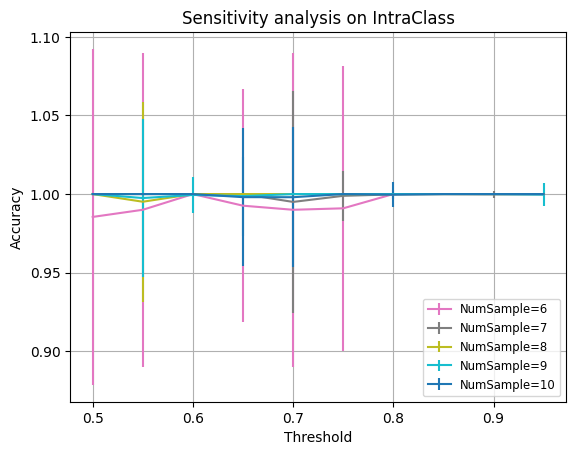

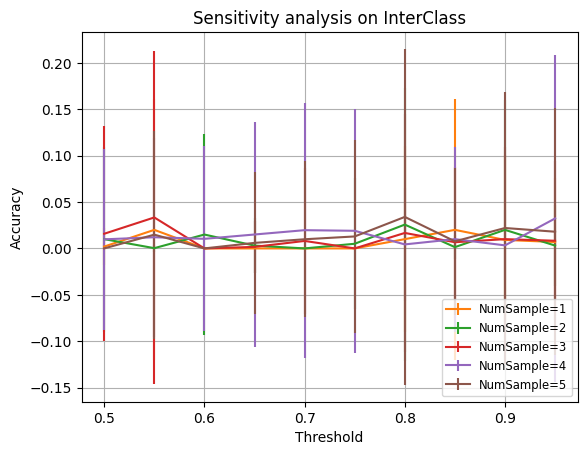

In [ ]:
samplerange=6
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
graphs=list(dataset)
for numsample in range(1,samplerange):
  threshold=0.5
  Threshold=[]
  Mean1=[]
  Std1=[]
  Mean2=[]
  Std2=[]
  while(threshold<1):
    Threshold.append(threshold)
    data1 , data2=Dpc(graphs,threshold)
    print(len(data1))
    print(len(data2))

    Bdist1, mean_estimate1, result1, Adj1 =GraphRepModel(N,data1)
    Bdist2, mean_estimate2, result2, Adj2 =GraphRepModel(N,data2)
    mean1,std1=sensitivityanalysis(N, Bdist1, mean_estimate1, result1, Adj1,numsample,label=0)
    Mean1.append(mean1)
    Std1.append(std1)
    mean2,std2=sensitivityanalysis(N, Bdist2, mean_estimate2, result2, Adj2,numsample,label=1)
    Mean2.append(mean2)
    Std2.append(std2)
    threshold+=0.05
  plot_mean_with_error(Mean1,Std1,Threshold,label='class1',numsample=numsample+5,title='Sensitivity analysis on IntraClass',ax=ax1)
  plot_mean_with_error(Mean2,Std2,Threshold,label='class2',numsample=numsample,title='Sensitivity analysis on InterClass',ax=ax2)

plt.show()

